# **Zebrafish Blender Workflow Walkthrough**
---
Author: Gary Han  
Date: Aug. 23, 2024  
*Based on Nikolas Claussen's tutorials with the drosophila. NOTE THIS IS STILL A WIP.*  

### NB
This is meant to be a read through notebook only! Some files that are used are too large to be uploaded to git so this may crash if you run it.

In [2]:
import numpy as np
from skimage import transform
from skimage.io import imread, imsave
import h5py
from typing import Iterable
import tifffile
import json
import os
from copy import deepcopy

In [3]:
import matplotlib.pyplot as plt
import mcubes

## Segmentation
---
`resolution_in_microns`: Originally the deconvolved image is 0.2493x0.2493x0.2493 microns per pixel.  
Since I downscaled the image by a factor of 0.3 for ease of use, the micron per pixel is now 0.2493/0.3 = 0.831 microns per pixel.  

Dimensions when being read in: `czyx` (You will want to know this when you're making your dataset for ilastik.)

In [7]:
from blender_tissue_cartography.io import adjust_axis_order

metadata_dict = {'filename': 'TP0_Ch0_Ill0_Ang0,45,90,135,180,225,270,315_16bit_DS',
                 'resolution_in_microns': (0.831, 0.831, 0.831), # you can typically get this from the .tif metadata
                 'subsampling_factors': (1/3, 1/3, 1/3),
                }
image = adjust_axis_order(imread(f"{metadata_dict['filename']}.tif"))
print("image shape:", image.shape) # image shape - spatial axes are in z-x-y order
subsampled_image = transform.rescale(image, metadata_dict['subsampling_factors'],
                                     channel_axis=0, preserve_range=True)
print("subsampled image shape:", subsampled_image.shape)

image shape: (1, 492, 387, 495)
subsampled image shape: (1, 164, 129, 165)


Now we write in a .h5 for input into ilastik. I used an autocontext (2-stage classification) in where I detected `background`, `embryo`, and `yolk` in the first stage and `inside` and `outside` in the second.

In [10]:
from blender_tissue_cartography.io import write_h5
write_h5(f"{metadata_dict['filename']}_subsampled.h5", subsampled_image)

Next, we read in the `probabilities` file.

In [11]:
from blender_tissue_cartography.io import read_h5
segmentation = read_h5(f"{metadata_dict['filename']}_subsampled-image_Probabilities Stage 2.h5")
segmentation = segmentation[0] # select the first channel of the segmentation - it's the probablity a pixel
                               # is part of the sample
print("segmentation shape:", segmentation.shape)

segmentation shape: (164, 129, 165)


We can then inspect our segmentation via `imshow` or in `FIJI`.

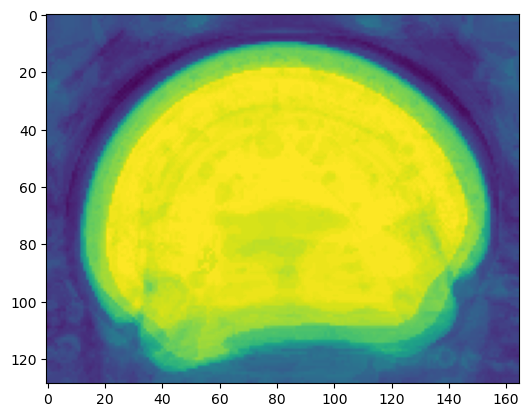

In [12]:
# look at the segmentation in a cross section
plt.imshow(segmentation[50, ...], vmin=0, vmax=1)

Next, we convert out segmentation into a mesh. You may want to play around with `sigma` as well as the level set values. You can visualize the mesh as a point cloud below.

In [13]:
from blender_tissue_cartography.io import flatten, ObjMesh

# now we create a 3d mesh of using the marching cubes method

level_set = mcubes.smooth(segmentation, method="gaussian", sigma=10) # converts segmentation into level set, with 0=surface
vertices, faces = mcubes.marching_cubes(level_set, 0.2) # may need to play around with the sigma and level set values

# EXTREMELY IMPORTANT - we now rescale the vertex coordinates so that they are in microns.
vertices_in_microns = vertices * (np.array(metadata_dict['resolution_in_microns'])
                                 /np.array(metadata_dict['subsampling_factors']))

mesh = ObjMesh(vertices_in_microns, faces)
mesh.name = "basics_example_mesh_marching_cubes"
mesh.write_obj(f"{metadata_dict['filename']}_mesh_marching_cubes.obj")

## Meshing
---
To start, we should re-compute the mesh using `pymeshlab` to make the faces look nicer (more uniform triangular mesh). (TODO: Compare meshes in blender)

In [14]:
import pymeshlab
ms = pymeshlab.MeshSet()
ms.load_new_mesh(f"{metadata_dict['filename']}_mesh_marching_cubes.obj")
# perform isotropic resampling of the mesh, i.e. more regularly shaped triangular faces
ms.meshing_isotropic_explicit_remeshing() 
ms.save_current_mesh(f"{metadata_dict['filename']}_mesh_remeshed.obj")

To check that all went well, we can visualize it.

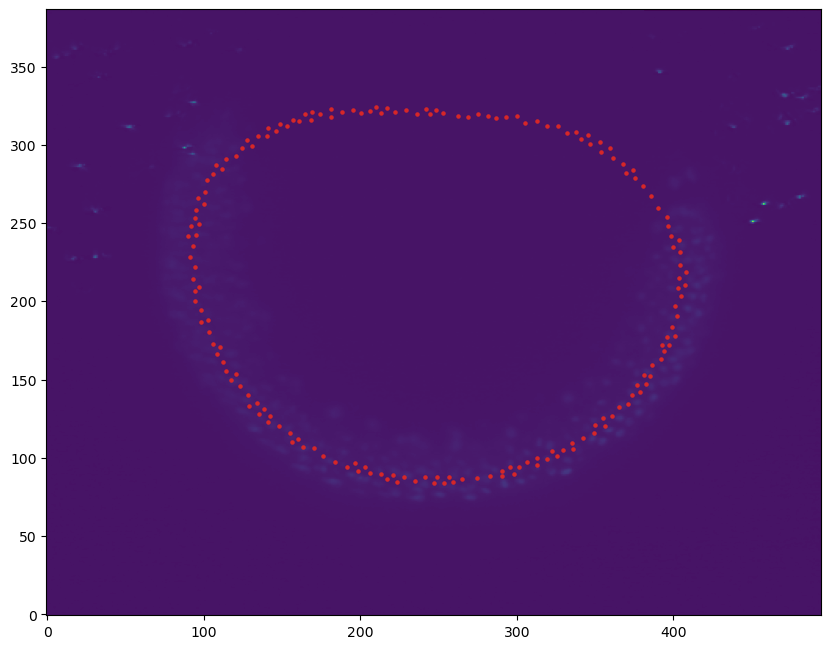

In [15]:
from blender_tissue_cartography.interpolation import get_cross_section_vertices_normals
image = adjust_axis_order(imread(f"{metadata_dict['filename']}.tif"))
mesh = ObjMesh.read_obj(f"{metadata_dict['filename']}_mesh_remeshed.obj")
slice_image, slice_vertices = get_cross_section_vertices_normals(0, 105,
                                image, mesh, metadata_dict["resolution_in_microns"], get_normals=False)
fig = plt.figure(figsize=(10,10))
plt.scatter(*slice_vertices[:,::-1].T, s=5, c="tab:red") 
plt.imshow(slice_image[0].T, origin="lower")

We can also visualize it in Blender. To do this open up blender and make a new `.blend` file. Next go to `file` $\rightarrow$ `import` $\rightarrow$ `Wavefront (.obj)` and select the file you want to visualize.  

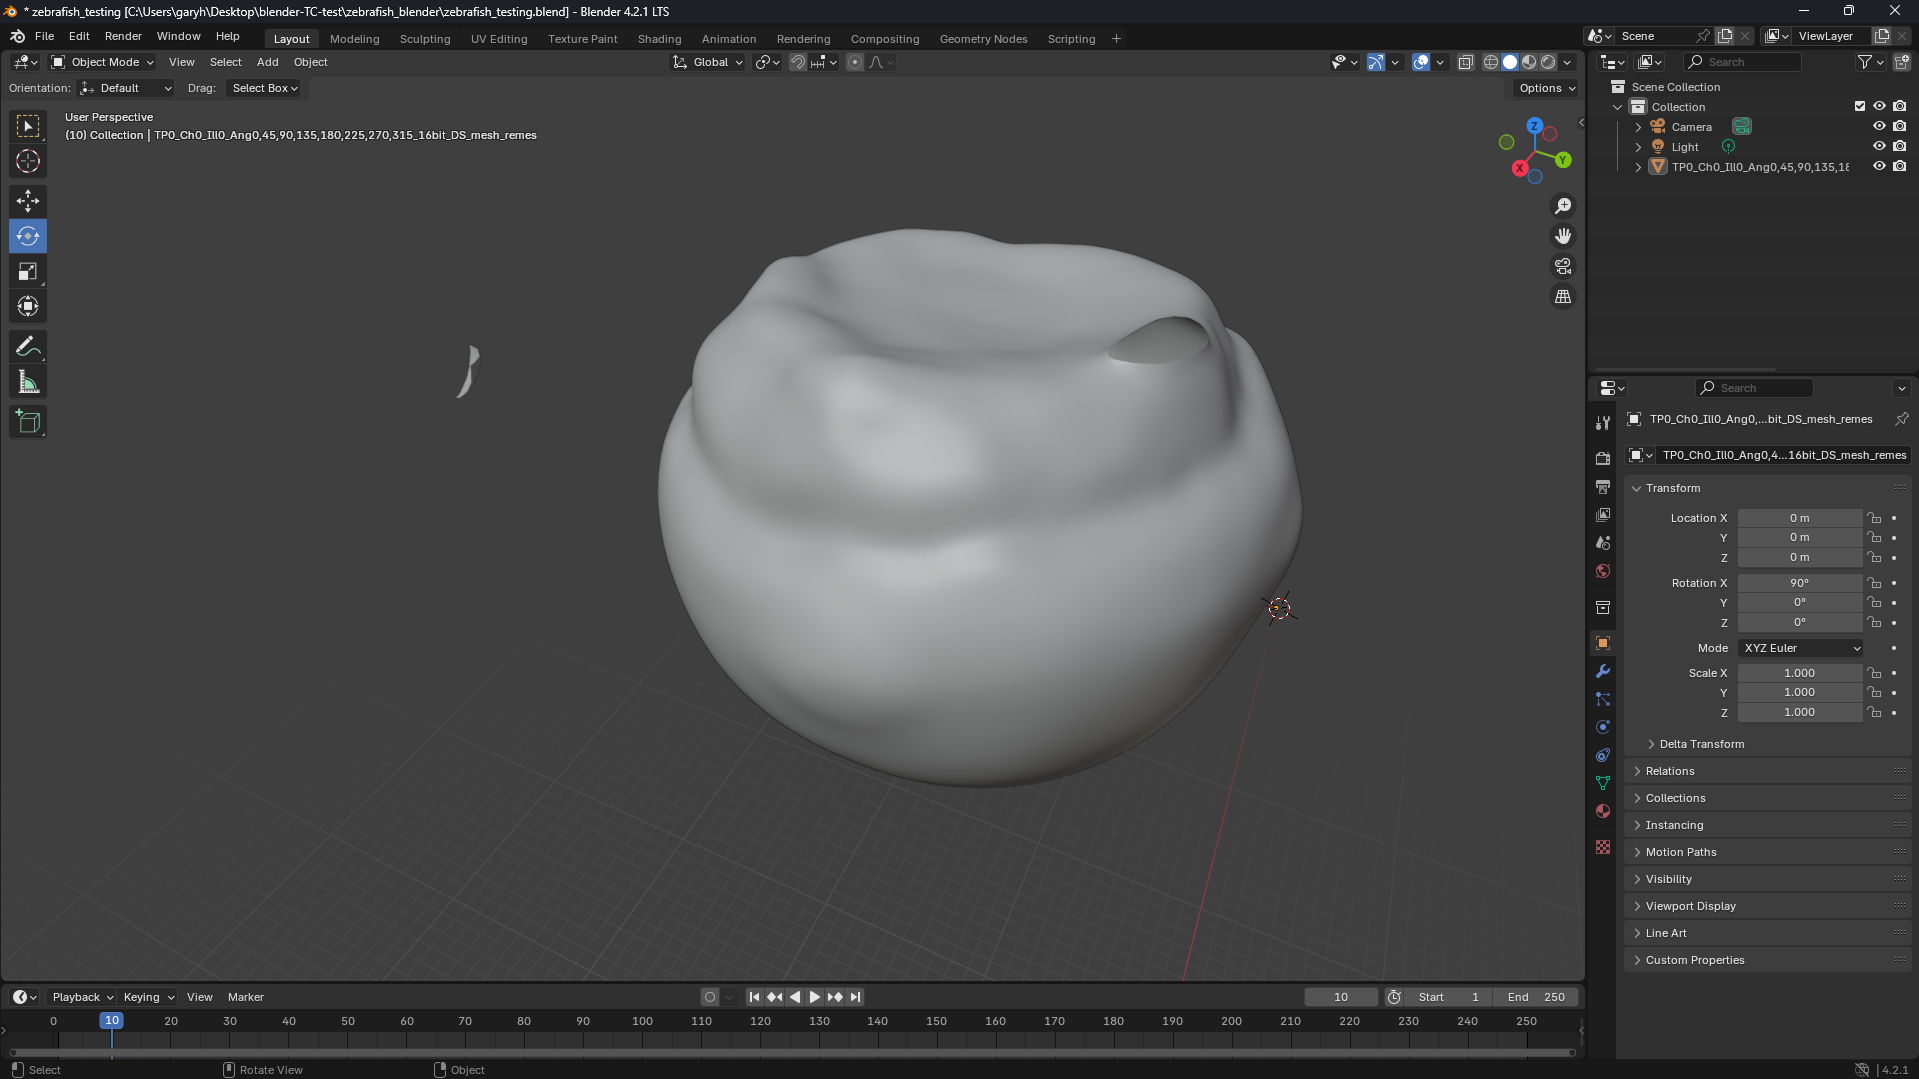  

Okay, our remeshed mesh isn't perfect. Holes and artifacts are present. We can fix this via `pymeshlab` or through Blender.  

> Blender tricks:  
> 
> `ctrl + middle click` to pan  
> `shift + middle click` to zoom  
> `middle click` to rotate  
> Clicking an vertex and hitting `ctrl + L` will select everything that is linked to that edge

## Mesh editing through Blender
---

### Filling holes
We will try to fix our mesh through Blender. First, make sure you lock the object position and rotation like so:

![fig01](notebook_figs\fig01.png)  

Next, go into click on the modeling tab and you should see the mesh on your object:

![fig02](notebook_figs\fig02.png)

Lets remove the artifact in the top left. Click `shift + spacebar` to bring up the quick actions menu and hit `b`. Select the artifact hit delete and click the first option. (Alternativly, select a vertex and hit `ctrl + L`)

![fig03](notebook_figs\fig03.png)  

To fix the holes, hit `a` to select the entire mesh, then go to `Mesh` $\rightarrow$ `Clean up` $\rightarrow$ `Fill holes`. If this doesn't work you can fill the holes manually, like so:

![fig04](notebook_figs/fig04.png)  

Select an edge on the border of the hole and `shift+click` an adjacent edge on the border. Next go to `Select` $\rightarrow$ `Select Loops` $\rightarrow$ `Edge Loops` and you should see all the edges along the loop selected. Finally hit `alt + F` to fill (alternatively: `Faces` $\rightarrow$ `Fill`) It should look something like this:

![fig05](notebook_figs/fig05.png)

### Smoothing Meshes
Navigate to the `Sculpting` tab. Click `s` to activate the smoothing tool. Clock on the mesh to smooth. Unfortunately there's not much to say about this step, it feels pretty adhoc, maybe there's a better way to do this with `pymeshlab`. 

A typical problem that arises while smoothing your mesh is that parts of it start to shrink, thus causing the mesh and your actual surface to be mis aligned over time. A fix would be the following:  
- In the right menu, navigate to the modifiers tab and hit add modifier.
- Add `Deform` $\rightarrow$ `Smooth Corrective` so smoothing will preserve volume.  
- Add `Deform` $\rightarrow$ `Smooth` 
- Add `Normals` $\rightarrow$ `WeightedNormals`   

You can learn more about modifiers [here](https://docs.blender.org/manual/en/latest/modeling/modifiers/)

## UV Mapping (IN PROGRESS)
---
Navigate to the `UV Editing` tab. Note now that you can enter different modes by pressing the following: `1` enters vertex mode, `2` enters edge mode and `3` enters face mode.   

Next, we want to define a seam along which to cut. This can be done by clicking `1`, selecting 1 vertex on one side of the mesh and selecting another vertex on the other side, hitting `2` to get the edges, and right clicking and selecting `Mark Seam`. You'll also want to select out poles on which you want to cut (I don't know if this is required). You should get something like the following:

![fig10](notebook_figs/fig10.png)

Click `3` and `a` then `UV` $\rightarrow$ `Unwrap` to unwrap the mesh. 

![fig11](notebook_figs/fig11.png)  

We can edit the pullbacks directly by transforming the meshes. There are many tools to do this in located in the UV window. Since we only care about the bigger island (that is our anterior-equidistant map) and not the smaller one, begin by resizing the smaller one and moving it to the corner. (TODO: FINISH THIS PART.)

![fig12](notebook_figs/fig12.png)

### TODO: Normal issues

`Mesh` $\rightarrow$ `Normals` $\rightarrow$ `Recalculate Outside`

### Exporting results
Go to `File` $\rightarrow$ `Export` $\rightarrow$ `Wavefront (.obj)` and select the following in the checklist (NB: filename):

![fig09](notebook_figs/fig09.png)  

## Cartographic projection
---
Previously, we saved the .obj file with the name `f"{metadata_dict['filename']}_mesh_uv.obj"`. We'll want to read it in. Furthermore, we also define some new variables as part of our `metadata_dict`.

In [8]:
normal_offsets = np.linspace(-3, 3, 11) # in microns
metadata_dict['normal_offsets'] = normal_offsets 
uv_grid_steps = 1024

We compute the cartographic projections and save the results in different formats.

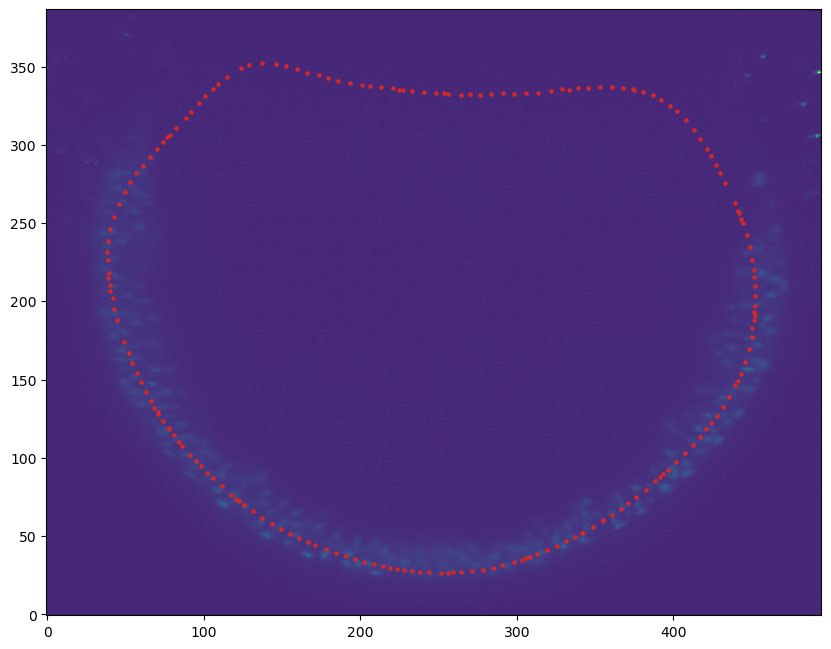

In [16]:
# visualize the new mesh
image = adjust_axis_order(imread(f"{metadata_dict['filename']}.tif"))
mesh = ObjMesh.read_obj(f"{metadata_dict['filename']}_mesh_uv.obj")
slice_image, slice_vertices = get_cross_section_vertices_normals(0, 260,
                                image, mesh, metadata_dict["resolution_in_microns"], get_normals=False)
fig = plt.figure(figsize=(10,10))
plt.scatter(*slice_vertices[:,::-1].T, s=5, c="tab:red") 
plt.imshow(slice_image[0].T, origin="lower")

In [17]:
from blender_tissue_cartography.interpolation import create_cartographic_projections
from blender_tissue_cartography.io import save_stack_for_blender, save_for_imageJ, save_dict_to_json

projected_data, projected_coordinates, projected_normals = create_cartographic_projections(
    image=f"{metadata_dict['filename']}.tif",
    mesh=f"{metadata_dict['filename']}_mesh_uv.obj",
    resolution=metadata_dict["resolution_in_microns"],
    normal_offsets=normal_offsets,
    uv_grid_steps=uv_grid_steps)

# save images for visualization in blender
texture_path = os.path.join(os.getcwd(), f"{metadata_dict['filename']}_textures") # f"{os.getcwd()}/{metadata_dict['filename']}_textures"
save_stack_for_blender(projected_data, texture_path, normalization=(0.01, 0.99))

# save images as .tif stack for analysis
save_for_imageJ(f"{metadata_dict['filename']}_projected.tif", projected_data, z_axis=1)
save_for_imageJ(f"{metadata_dict['filename']}_3d_coordinates.tif", projected_coordinates)
save_for_imageJ(f"{metadata_dict['filename']}_normals.tif", projected_normals)

# save the metadata to a human and computer readable file
save_dict_to_json(f"{metadata_dict['filename']}_metadata.json", metadata_dict)

We can visualize the pullbacks in python.

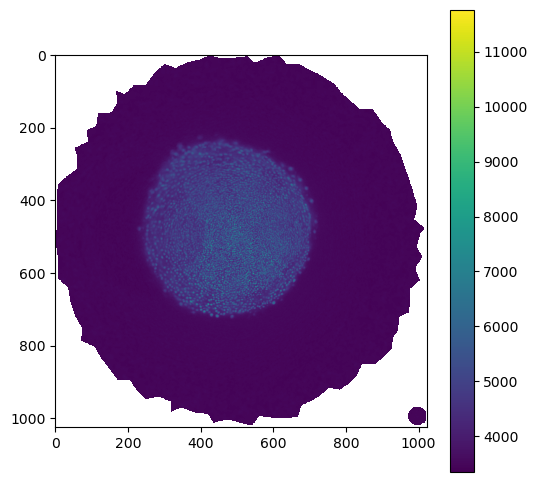

In [18]:
# show the projected data
fig = plt.figure(figsize=(6,6))
plt.imshow(projected_data[0, 4])
plt.colorbar()

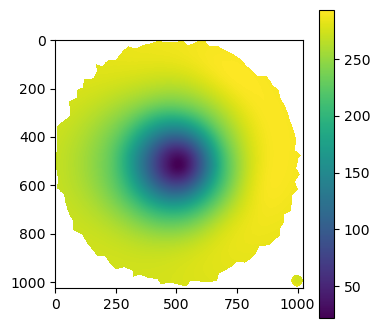

In [19]:
# show the projected 3d coordinates
fig = plt.figure(figsize=(4,4))
plt.imshow(projected_coordinates[...,1])
plt.colorbar()